In [18]:
 # Created Jan 9, 2022
# Updated Jan 9, 2022
import sys; sys.path.insert(0, '../../') ## make sure path to root of project directory
from wu_barcodes.config import *

import matplotlib as mpl
# mpl formatting
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl_configs)
import methods.ax_methods as ax_methods
import numpy as np; rnd = np.random.default_rng()
import scipy.stats

import pickle
import methods.sim_barcodes as sim

In [19]:
import methods.filter_lineages as fl

import scipy.ndimage.filters as ndif
def running_mean_uniform_filter1d(x, N):
    return ndif.uniform_filter1d(x, N, mode='reflect', origin=0)

def heat_map(ax, bac, m1, m2, day, day0_read_range):
    print('*** Plotting joint distribution of reads ***')
    row_ids = fl.bac_row_ids[bac]
    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]

    d0_reads = read_array[0]

    m1_reads = np.copy( read_array[ row_ids[(m1, day)] ] )
    m2_reads = np.copy( read_array[ row_ids[(m2, day)] ] )

    print(f'Seq. Depths of Mice={(m1_reads.sum(), m2_reads.sum())}')

    day0_min, day0_max = day0_read_range
    lineage_indices = (d0_reads >= day0_min) * (d0_reads < day0_max) #* (m1_d4_reads > 0) * (m2_d4_reads > 0)
    print(f'# lineages={lineage_indices.sum()}')

    ## plot empirical
    binspace = np.linspace(0, 80, 81)
    ax.hist2d(m1_reads[lineage_indices], m2_reads[lineage_indices], bins=binspace, norm=mpl.colors.LogNorm(0.1, 100), cmap=mpl.cm.Oranges)
    r, pval = scipy.stats.pearsonr(m1_reads[lineage_indices], m2_reads[lineage_indices])
    print(f'r, pval = {r:.2f}, {pval:.1e}')

    ax.set_xlabel('mouse {} day 4 reads'.format(m1))
    ax.set_ylabel('mouse {} day 4 reads'.format(m2))

    ax.set_xlim(0, 80)
    ax.set_ylim(0, 80)
    ax.axvspan( day0_min * m1_reads.sum() / d0_reads.sum(), day0_max * m1_reads.sum() / d0_reads.sum(), color='grey', alpha=0.5, zorder=0)
    ax.axhspan( day0_min * m2_reads.sum() / d0_reads.sum(), day0_max * m2_reads.sum() / d0_reads.sum(), color='grey', alpha=0.5, zorder=0)
    ax.plot( ax.get_xlim(), np.array(ax.get_xlim()) * m2_reads.sum()/m1_reads.sum(), color='black', linestyle='dashed')

def calc_coarse_grained_lfc_array(freqs0, D0, freqs1, D1, dt, coarse_grain=100):
    cg_freqs0 = running_mean_uniform_filter1d(freqs0, coarse_grain)
    cg_freqs1 = running_mean_uniform_filter1d(freqs1, coarse_grain)

    cg_f0, cg_f1 = fl.maxmin_freqs(cg_freqs0, D0, cg_freqs1, D1)

    with np.errstate(divide='ignore'):
        return np.log( cg_f1/cg_f0 ) / dt

with open('../figure1_muller_and_transition/10biggest_indices.pkl', 'rb') as f:
    muller_lineage_dict = pickle.load(f)


/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt


0.162


/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt


0.186
0.129


/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: invalid value encountered in log
  return np.log( freqs1/freqs0 ) / dt


0.303


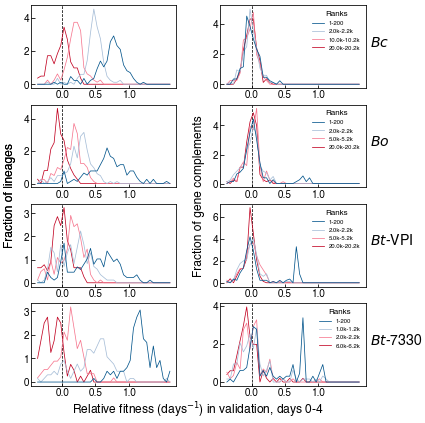

In [21]:
BAC_DRAWS = {'BWH2':15000, 'Bovatus':10000, 'BtVPI':10000, 'Bt7330':4000}


fig = plt.figure(figsize=(6, 7))
outer = mpl.gridspec.GridSpec(nrows=4, ncols=3, width_ratios=(1,0.03,1), figure=fig)
outer_ax = fig.add_subplot(outer[:, :])
ax_methods.turn_off_ax(outer_ax)
outer_ax.set_xlabel(r'Relative fitness (days$^{-1}$) in validation, days 0-4', labelpad=7, fontsize=12)
outer_ax.set_ylabel(r'Fraction of lineages', labelpad=5, fontsize=12)

lineage_col = fig.add_subplot(outer[:, 0])
lineage_col.set_ylabel(r'Fraction of lineages', labelpad=5, fontsize=12)
ax_methods.turn_off_ax(lineage_col)
# lineage_col.set_title('Adaptive lineage', fontsize=12)
gene_col = fig.add_subplot(outer[:, 2])
gene_col.set_ylabel(r'Fraction of gene complements', labelpad=5, fontsize=12)
ax_methods.turn_off_ax(gene_col)
# gene_col.set_title('Gene complement', fontsize=12)



k=5
norm = True
thresholding = 'MaxOr'
### rank order curves
if 'plot rank order curves, etc':
    min_reads = 5
    gene_nn = False
    cutoff = 10**-6.5
    cg = 100 #coarse_grain

    discovery_mice = [6, 7, 8, 9, 10]
    validation_mice = [1, 2, 3, 5]

    # discovery_mice = [11, 12, 13, 15]
    # validation_mice = [16, 18, 19]

    discovery_d0, discovery_d1 = 0, 4
    discovery_dt = discovery_d1 - discovery_d0
    validation_d0, validation_d1 = 0, 4
    validation_dt = validation_d1 - validation_d0

for b, (bac, n_fit) in enumerate([('BWH2', 100000), ('Bovatus', 100000),
                                  ('BtVPI', 100000), ('Bt7330', 100000)]):
    if 'generate discovery and validation frequencies':
        discovery_reads0, discovery_reads1 = np.copy(fl.get_read_arrays(bac, discovery_mice, discovery_d0, discovery_d1, split_day0=2))
        validation_reads0, validation_reads1 = np.copy(fl.get_read_arrays(bac, validation_mice, validation_d0, validation_d1, split_day0=1))
        # discovery_reads0 -= fl.bac_input_arrays[bac][6][fl.bac_nonwu_indices[bac]]

        discovery_D0, discovery_D1 = discovery_reads0.sum(), discovery_reads1.sum()
        discovery_freqs0, discovery_freqs1 = discovery_reads0 / discovery_D0, discovery_reads1 / discovery_D1

        validation_D0, validation_D1 = validation_reads0.sum(), validation_reads1.sum()
        validation_freqs0, validation_freqs1 = validation_reads0 /validation_D0, validation_reads1 /validation_D1

        d0_reads = fl.bac_read_arrays[bac][0][fl.bac_nonwu_indices[bac]]
        d0_freqs = d0_reads / d0_reads.sum()
        d1_reads = (discovery_reads1 + validation_reads1)

        max_freqs = np.max([discovery_freqs0, discovery_freqs1], axis=0)
        d_valid = fl.filter_lineages(discovery_reads0, discovery_reads1, min_reads=min_reads, threshold=max_freqs)
        v_valid = fl.filter_lineages(validation_reads0, validation_reads1, min_reads=min_reads, threshold=max_freqs)

        filtered_bool =  (d0_freqs > cutoff) * v_valid
        lineage_indices = rnd.permutation( np.arange(d0_freqs.shape[-1])[filtered_bool] )

        d_f0, d_f1 = fl.maxmin_freqs(discovery_freqs0, discovery_D0, discovery_freqs1, discovery_D1)
        v_f0, v_f1 = fl.maxmin_freqs(validation_freqs0, validation_D0, validation_freqs1, validation_D1)

    if 'generate sorted fitnesses':
        fit_indices, sorted_fitnesses = fl.rank_barcodes(d_f0[lineage_indices], d_f1[lineage_indices], discovery_dt)
        fit_indices = lineage_indices[fit_indices]

        n_fit = filtered_bool.sum()
        v_f0_fit, v_f1_fit = v_f0[fit_indices][:n_fit], v_f1[fit_indices][:n_fit]
        d_freqs0_fit, d_freqs1_fit = discovery_freqs0[fit_indices][:n_fit], discovery_freqs1[fit_indices][:n_fit]
        v_freqs0_fit, v_freqs1_fit = validation_freqs0[fit_indices][:n_fit], validation_freqs1[fit_indices][:n_fit]
        validation_lfcs = fl.calc_lfc_array(v_f0_fit, v_f1_fit, validation_dt)

        cg_validate_lfcs = calc_coarse_grained_lfc_array(v_freqs0_fit, validation_D0, v_freqs1_fit, validation_D1,
                                                         validation_dt, coarse_grain=cg)
        gene_complement_f0, gene_complement_f1 = fl.calc_gene_complement_freqs(bac, fit_indices[:n_fit], validation_freqs0, validation_freqs1, nearest_neighbors=gene_nn, cutoff=cutoff)
        gene_complement_lfcs = fl.calc_lfc_array(gene_complement_f0, gene_complement_f1, validation_dt)

        cg_gene_complement_lfcs = calc_coarse_grained_lfc_array(gene_complement_f0, validation_D0, gene_complement_f1, validation_D1,
                                                                validation_dt, coarse_grain=cg)
    if bac == 'BWH2':
        rank_ranges = [(1, 200), (2000, 2200), (10000, 10200), (20000, 20200)]
    elif bac != 'Bt7330':
        rank_ranges = [(1, 200), (2000, 2200), (5000, 5200), (20000, 20200)]
    else:
        rank_ranges = [(1, 200), (1000,1200), (2000, 2200), (6000, 6200)]

    # rank_ranges = [(1000, 1200)]

    # cmap = plt.cm.get_cmap( 'Blues_r' ) #
    # cmap = list(iter(cmap(np.linspace(0, 0.8, len(rank_ranges)+1)))
    cmap = [KELLY_COLORS[i] for i in [9,3,8,4]]
    if 'rank order plot':
        print(gene_complement_lfcs.mask[:1000].sum()/gene_complement_lfcs[:1000].shape[0])
        lineage_ax = fig.add_subplot(outer[b, 0])
        gene_ax = fig.add_subplot(outer[b, 2])

        # z = rnd.choice(np.arange(gene_complement_lfcs.shape[0]), size=200)
        # rnd_gene_lfcs = gene_complement_lfcs[z]
        # rnd_density, bins = np.histogram(rnd_gene_lfcs[~rnd_gene_lfcs.mask], bins=np.linspace(-0.4,1.5,39), density=True)
        # gene_ax.plot(bins[1:], rnd_density, color='grey')

        bins = np.linspace(-0.4,1.65,42)
        avg_bins = (bins[:-1] + bins[1:])/2
        for i, (rank0, rank1) in enumerate(rank_ranges):

            gene_valid = ~gene_complement_lfcs.mask[rank0:rank1]
            density, bins = np.histogram(validation_lfcs[rank0:rank1][gene_valid], bins=bins, density=True)
            gene_density, bins = np.histogram(gene_complement_lfcs[rank0:rank1][gene_valid], bins=bins, density=True)
            cdf = np.cumsum(density) / density.sum()
            if rank0 >= 1000:
                label_rank0 = f'{rank0 / 1000:.1f}k'
                label_rank1 = f'{rank1 / 1000:.1f}k'
            else:
                label_rank0 = rank0
                label_rank1 = rank1
            lineage_ax.plot(avg_bins, density, color=cmap[i], label=f'{label_rank0}-{label_rank1}', zorder=5-i)
            gene_ax.plot(avg_bins, gene_density, color=cmap[i], label=f'{label_rank0}-{label_rank1}', zorder=5-i)
        # ax.set_xlim(0, ax.get_xlim()[1])
        # ax.text(0.6, 0.85, BAC_FORMAL_NAMES[bac], transform=ax.transAxes, color='black')
        gene_ax.legend(title=f'Ranks', frameon=False)
        lineage_ax.axvline(0, linestyle='dashed', color='black', zorder=0)
        gene_ax.axvline(0, linestyle='dashed', color='black', zorder=0)

    # gene_ax.set_ylabel(f'{BAC_FORMAL_NAMES[bac]}', fontsize=10)
    # lineage_ax.set_ylabel(f'{BAC_FORMAL_NAMES[bac]}', fontsize=10)
    gene_ax.text(1.03, 0.5, f'{BAC_FORMAL_NAMES[bac]}',
                    transform=gene_ax.transAxes, fontsize=14, weight='bold')
    gene_ax.tick_params(axis='both', labelsize=10)
    lineage_ax.tick_params(axis='both', labelsize=10)
    gene_ax.set_xticks([0, 0.5, 1])
    lineage_ax.set_xticks([0, 0.5, 1])

# if norm:
#     fig.savefig(f'SI_fig2_rank_order_slices_normed.pdf')
# else:
#     fig.savefig(f'SI_fig2_HF_rank_order_slices.pdf')

fig.savefig(f'{biorxiv}/SI_HF_rank_order_slices.pdf')